In [57]:
using LinearAlgebra
import Pkg
Pkg.add("Plots")
using Plots
Pkg.add("LaTeXStrings")
using LaTeXStrings

   Resolving package versions...
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Manifest.toml`
Precompiling project...
  ✗ PyCall
  ✗ PyPlot
  0 dependencies successfully precompiled in 6 seconds. 174 already precompiled.
  2 dependencies errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the packages
   Resolving package versions...
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Manifest.toml`


In [58]:
using Fermions

Anderson impurity model with 1 atom and several bath sites (not half-filled)
----------------------------------------------------------------------------------------

$$
H = -\mu \sum_\sigma c^\dagger_{1\sigma} c_{1\sigma} + U n_{1\uparrow} n_{1\downarrow} 
+ \sum_{i>1,\sigma} V_{1i} c^\dagger_{1\sigma} c_{i\sigma} + h.c. - \sum_{i>1,\sigma} \epsilon_{i} c^\dagger_{i\sigma} c_{i\sigma}
$$
where the flavours are $\uparrow1, \uparrow2, \uparrow3, \downarrow1, \downarrow2, \downarrow3 \cdots$

In [59]:
nsites = 5
#t = 1.0
u = 2.0
mu = 1.33168

# 6 bath sites (GF is fast, but P3 takes quite long)
#epsilons = [-3.3222061 , -1.39508342, -0.27908811,  0.36578404,  1.62122836,
 #       3.76701005]
#vksq = [0.70669434, 0.88584406, 0.33253184, 0.33283158, 0.96772167,
  #     0.77189007]

# 5 bath sites
#epsilons = [-2.79245855, -0.8460881 ,  0.00907373,  1.00479852,  3.17202384]
#vksq = [1.06150688, 0.73752328, 0.23223445, 0.79217678, 1.16486242]

# 4 bath sites
epsilons = [-2.22846159, -0.36627436,  0.45552273,  2.5497922 ]
vksq = [1.41296559, 0.4824027 , 0.49958433, 1.54991471]
vks = sqrt.(vksq)

4-element Vector{Float64}:
 1.1886822914471302
 0.6945521578686513
 0.7068127969979039
 1.2449557060393754

First, we need to create a finite Fock space. Since we have `nsites` sites with two spins each, the number of flavours is `2 * nsites`

In [60]:
space = FockSpace(2 * nsites)

FockSpace(10, 0x00000000000003ff)

To express the Hamiltonian above, we need the annihilation operators
$c_{i\sigma}$. `annihilators` returns an array of these objects. Now,
to add a spin dimension, we simply reshape that array so that the second index corresponds to a spin index.

In [61]:
c = reshape(annihilators(space), (nsites, 2))

5×2 Matrix{Operator{Int8, Tuple{Term{Int8}}}}:
 1 c[1]  1 c[6]
 1 c[2]  1 c[7]
 1 c[3]  1 c[8]
 1 c[4]  1 c[9]
 1 c[5]  1 c[10]

The creation operator is simply given by conjugate transpose, e.g., `c[1,1]'`.  A normal ordered product (`Term`) can now be formed by simply multiplying operators:

Creating the Hamiltonian now involves a sum of terms.  For this,
we create a `Operator` instance and simply add terms to it:

In [62]:
H = Operator(space)
H -= mu * (c[1,1]' * c[1,1] + c[1,2]' * c[1,2]) 
H += u * c[1,1]' * c[1,2]' * c[1,2] * c[1,1]
for i in 2:nsites
    for σ in 1:2
        H -= epsilons[i-1] * c[i,σ]' * c[i,σ]
        H += vks[i-1] * (c[1,σ]' * c[i,σ] + c[i,σ]' * c[1,σ])
    end
end
H

Operator{Float64, Vector{Term{Float64}}} for 10 flavours (27 terms):
1.2449557060393754 c[6]' c[10]
0.7068127969979039 c[6]' c[9]
0.6945521578686513 c[6]' c[8]
1.1886822914471302 c[6]' c[7]
1.2449557060393754 c[1]' c[5]
0.7068127969979039 c[1]' c[4]
0.6945521578686513 c[1]' c[3]
1.1886822914471302 c[1]' c[2]
-1.33168 n[1]
2.22846159 n[2]
0.36627436 n[3]
-0.45552273 n[4]
-2.5497922 n[5]
-1.33168 n[6]
2.0 n[1] n[6]
2.22846159 n[7]
0.36627436 n[8]
-0.45552273 n[9]
-2.5497922 n[10]
1.1886822914471302 c[2]' c[1]
0.6945521578686513 c[3]' c[1]
0.7068127969979039 c[4]' c[1]
1.2449557060393754 c[5]' c[1]
1.1886822914471302 c[7]' c[6]
0.6945521578686513 c[8]' c[6]
0.7068127969979039 c[9]' c[6]
1.2449557060393754 c[10]' c[6]

In [63]:
ishermitian(H)

true

**On-the-fly evaluation**

The elements are not stored anywhere, which means the size grows only with the number of terms:

If we want to construct a CSC sparse matrix from the operator, then one 
can use the `sparse()` function.  For small matrices, one can also
use the `Array()` function to get a dense matrix instead.

Using symmetries
----------------

Even with on-the-fly evaluation, the Fock space will grow too quickly,
which bars us from constructing the vectors.  However, we can remedy
that using symmetries.

The Hamiltonian conserves the total number of particles $N$ as well
as the total spin in $z$-direction $S_{z,tot}$.  We construct a
set of quantum numbers for those:

In [64]:
quantum_numbers = NSzSet(space)

NSet{2}(FockSpace(10, 0x00000000000003ff), 5, 5)

In [65]:
conserves(quantum_numbers, H)

true

This partitions the Fock space into a set of blocks

**Block operator**

We can also construct just one block for some values of quantum numbers.
For example, the following gets only the block with a filling close to
half in each spin.

In [66]:
using Fermions.Propagators
Pkg.add("SparseIR")
using SparseIR

   Resolving package versions...
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Manifest.toml`


In [67]:
beta = 10

10

In [68]:
ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, beta)

HamiltonianEigen{Operator{Float64, Vector{Term{Float64}}}, NSet{2}, Tuple{Int64, Int64}, Fermions.NSetBlock{2}, Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}}(1.2449557060393754 c[6]' c[10]
0.7068127969979039 c[6]' c[9]
0.6945521578686513 c[6]' c[8]
1.1886822914471302 c[6]' c[7]
1.2449557060393754 c[1]' c[5]
0.7068127969979039 c[1]' c[4]
0.6945521578686513 c[1]' c[3]
1.1886822914471302 c[1]' c[2]
-1.33168 n[1]
2.22846159 n[2]
0.36627436 n[3]
-0.45552273 n[4]
-2.5497922 n[5]
-1.33168 n[6]
2.0 n[1] n[6]
2.22846159 n[7]
0.36627436 n[8]
-0.45552273 n[9]
-2.5497922 n[10]
1.1886822914471302 c[2]' c[1]
0.6945521578686513 c[3]' c[1]
0.7068127969979039 c[4]' c[1]
1.2449557060393754 c[5]' c[1]
1.1886822914471302 c[7]' c[6]
0.6945521578686513 c[8]' c[6]
0.7068127969979039 c[9]' c[6]
1.2449557060393754 c[10]' c[6], NSet{2}(FockSpace(10, 0x00000000000003ff), 5, 5), Dict{Tuple{Int64, Int64}, Fermions.NSetBlock{2}}((4, 5) => Fermions.NSetBlock{2}(nflv=10, Ntot=4, Ntot=5), (1, 2) => Fermio

We can use the `full_tau` function of the Propagators module: it expects the operators and a tau grid to use:

The Fourier transform is available using the `full_freq` function:
$$
    \hat G(i\omega_n) = \int_0^\beta \exp(i\omega_n\tau) G(\tau) d\tau
$$
The Matsubara frequencies have to be specified as `FermionicFreq` or
`BosonicFreq` objects, where the argument is the prefactor to $i\pi/\beta$, i.e., odd numbers for fermionic frequencies and even numbers for bosonic
frequencies.

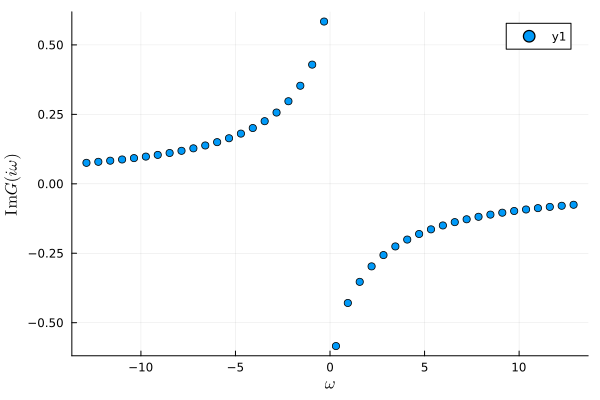

In [69]:
#import Pkg
#Pkg.add("Plots")
using Plots

A = -c[1, 1]
B = c[1, 1]'

wn = FermionicFreq(-41):FermionicFreq(41)
w = SparseIR.value.(wn, beta);

giw = full_freq((A, B), wn, ham_eb, beta)

Plots.scatter(w, imag.(giw), xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")

In [70]:
#import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
using CSV
using DataFrames

data = CSV.read("data.csv", DataFrame, delim=" ",ignorerepeated=true, header=false) 

   Resolving package versions...
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\MarkusReichel\.julia\environments\v1.8\Manifest.toml`


Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,String15,Int64,Int64,Int64,Float64,Float64,Float64
1,dmft-005,1,1,1,-30.4734,0.000244908,0.0326401
2,dmft-005,1,1,1,-29.8451,0.000255173,0.0333198
3,dmft-005,1,1,1,-29.2168,0.00026606,0.0340281
4,dmft-005,1,1,1,-28.5885,0.000277566,0.0347672
5,dmft-005,1,1,1,-27.9602,0.000289904,0.0355388
6,dmft-005,1,1,1,-27.3319,0.000303079,0.0363452
7,dmft-005,1,1,1,-26.7035,0.000317175,0.0371888
8,dmft-005,1,1,1,-26.0752,0.000332351,0.0380722
9,dmft-005,1,1,1,-25.4469,0.000348523,0.0389984


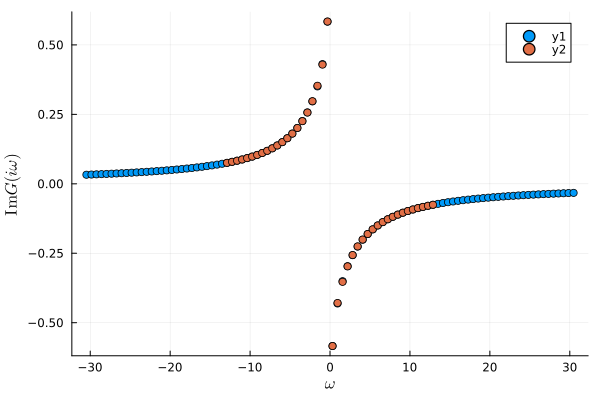

In [71]:
giw_origin_im = data[!,7]
#giw_origin_re = data[!,6]
w_origin = data[!,5]
plt=Plots.scatter(w_origin, giw_origin_im, xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")
#plt=Plots.scatter(w_origin, giw_origin_re, xlabel=L"\omega", ylabel=L"\mathrm{Re} G(i\omega)")
Plots.scatter!(plt,w, imag.(giw), xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")

Multi-point Green's function
----------------------------

To compute Greens functions of the form:
$$
    G_{ABC}(\tau') = \langle T A(\tau) B(\tau') C(0) \rangle
$$
from the Lehmann representation, we can use the same function,
but we need to specify three operators and a list of tuples
$(\tau,\tau')$.

In [89]:
# split the area into two simplices

using SimplexQuad

function G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1, ω2, τ_arr1, τ_arr2, weights, ham_eb)
    #temp=transpose(weights*ℯ.^(im*ω2*transpose(τ_arr2.*β))*transpose(ones(length(weights))*ℯ.^(im*ω1*transpose(τ_arr1.*β))*G_ABC(A,B,C,τ_arr1.*β,τ_arr2.*β,H,β,space,0.0)))
    #return temp
    
    #w=transpose(ones(length(weights)))
    #weightmatrix = transpose(weights*w)
    #println(weightmatrix)
    
    f_vector = Array{typeof(zero(ComplexF64)), 1}(undef,length(τ_arr1))
    
    for f in 1:length(f_vector) 
        f_vector[f] = 0
    end
    
    #println(size(weights))
    #println(size(τ_arr1))
    #println(size(f_vector))
    
    #tautau = collect(Iterators.product(τ_arr1*β,τ_arr2*β))
    tautau = []
    for f in 1:length(f_vector)
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        push!(tautau, (τ_1*β,τ_2*β))
    end
    #print(tautau)
    #Tuple(Float64(x) for x in pointlist)
    
    #f_vector = (ℯ.^(im*ω1*transpose(τ_arr1)*β)) * full_tau((A1,B1,C1), tautau, ham_eb, β) * (ℯ.^(im*transpose(ω2)*τ_arr2*β))
    
    #matrix1 = (ℯ.^(im*ω1*transpose(τ_arr1)*β))
    matrix2 = full_tau((A,B,C), tautau, ham_eb, β) 
    #matrix3 = (ℯ.^(im*transpose(ω2)*τ_arr2*β))
    
    
    for f in 1:length(f_vector) 
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        
        #f_vector[f] = ℯ.^(im*ω1*τ_1*β)*G_ABC(A,B,C,[τ_1*β],[τ_2*β],H,β,space,0.05)[1,1]*ℯ.^(im*ω2*τ_2*β)
        #f_vector[f] = ℯ.^(im*ω1*τ_1*β)* full_tau((A1,B1,C1), tautau, ham_eb, β)[1,1] * ℯ.^(im*ω2*τ_2*β)
        f_vector[f] = ℯ.^(im*ω1*τ_1*β)* matrix2[f] * ℯ.^(im*ω2*τ_2*β)
    end
    #println(dot(weights*β*β,f_vector))
    #println("------")
    

    return dot(weights*β*β,f_vector)
    
    #println(size(f_vector))
    #return weights*β*β*f_vector
    
end

function G_ABC_gl_transform_simplex(A, B, C, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+0)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+0)*π/β
    
    X, W = simplexquad(50, 2)
    Y=1 .-X
    
    
    quantum_numbers = NSzSet(space)
    ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, beta)
    
    #G_fun1 = G_ABC(A,B,C,(1 .-X[:,1])*β,(X[:,2])*β,H,β,space,0.05)
    #G_fun2 = G_ABC(A,B,C,(1 .-Y[:,1])*β,(Y[:,2])*β,H,β,space,0.05)
    
    #println((X))
    
    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    

            values1 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-X[:,1],X[:,2],W, ham_eb)
            values2 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-Y[:,1],Y[:,2],W, ham_eb)
            #println(W)
            #println(values1)
            #println(values2)

            #integral = dot(W,values1)+dot(W,values2)
            integral = values1+values2

            #println("Done with ", j, ", ", k)
            #println(size(integral))
            result[j,k] = integral
        end
    end
    #result = integral
    return result
end




G_ABC_gl_transform_simplex (generic function with 1 method)

In [73]:
wn = BosonicFreq(-30):BosonicFreq(30)
ww = collect(Iterators.product(wn, wn))
w = SparseIR.value.(wn, beta);

A1 = c[1, 1]' * c[1, 1]
B1 = c[1, 1]' * c[1, 1]
C1 = c[1, 1]' * c[1, 1]

tau = 0:0.1:beta
tautau = collect(Iterators.product( tau,tau))

@time R1_tau = full_tau((A1,B1,C1), tautau, ham_eb, beta)

""
#plot(tau,tau,real.(R1_tau), st=:surface)

  0.368439 seconds (8.04 k allocations: 12.880 MiB)


""

In [74]:
@time R1_omega = G_ABC_gl_transform_simplex(A1, B1, C1, H, beta, space, 11, 11)


 57.680726 seconds (10.26 M allocations: 11.866 GiB, 2.84% gc time, 0.32% compilation time)


23×23 Matrix{ComplexF64}:
   0.21553-4.94049e-15im  …  -0.286856+0.0im
 -0.563261-5.32907e-15im       2.40285-7.43849e-15im
  0.811988+1.06581e-14im      0.994138-6.21725e-15im
   -3.5436-2.03171e-14im     -0.774493+2.44249e-15im
   1.29286+6.88338e-15im      0.703173-1.11022e-16im
  -1.10749-5.60663e-15im  …   0.411326-4.66294e-15im
 -0.649443-2.96985e-15im      0.721662-7.7785e-15im
 -0.543647-4.21885e-15im     -0.310328-3.05311e-16im
 -0.787772-2.55351e-15im       2.22955-1.04361e-14im
 -0.470557-3.20577e-15im       1.76156-9.37445e-15im
 -0.318979-2.94209e-15im  …   0.701329-3.41394e-15im
 -0.610366+3.55271e-15im     -0.610366-3.55271e-15im
  0.701329+3.41394e-15im     -0.318979+2.94209e-15im
   1.76156+9.37445e-15im     -0.470557+3.20577e-15im
   2.22955+1.04361e-14im     -0.787772+2.55351e-15im
 -0.310328+3.05311e-16im  …  -0.543647+4.21885e-15im
  0.721662+7.7785e-15im      -0.649443+2.96985e-15im
  0.411326+4.66294e-15im      -1.10749+5.60663e-15im
  0.703173+1.11022e-16im     

21.25837678797891


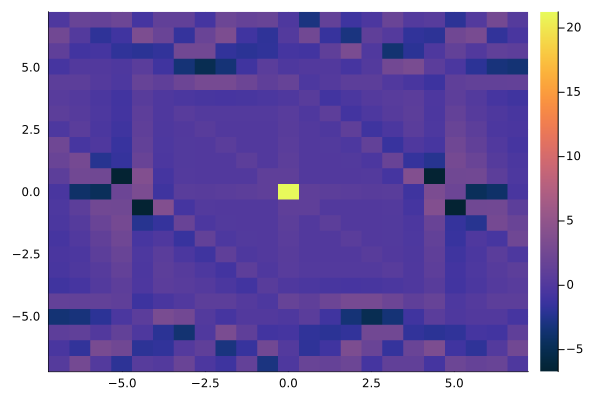

In [75]:
wn = BosonicFreq(-22):BosonicFreq(22)
ww = collect(Iterators.product(wn, wn))
w = SparseIR.value.(wn, beta);
#println(w)
#println(maximum(real.(R1_omega)))
#plot(w,w,real.(R1_omega), st=:surface)
#plot(w,w,real.(R1_omega))

#Pkg.add("PyPlot")
#using PyPlot;
#surf(w, w, real.(R1_omega))

#heatmap(w, w, real.(R1_omega), c = :thermal)


function showMeThe(R_what)
   wn = BosonicFreq(-22):BosonicFreq(22)
    ww = collect(Iterators.product(wn, wn))
    w = SparseIR.value.(wn, beta);
    #println(w)
    println(maximum(real.(R_what)))
    #plot(w,w,real.(R1_omega), st=:surface)
    heatmap(w, w, real.(R_what), c = :thermal) 
end

showMeThe(R1_omega)

In [76]:
A4 = c[1, 1]' * c[1, 1]
B4 = c[1, 1]' * c[1, 1]
C4 = c[1, 2]' * c[1, 2]

R4_tau = full_tau((A4,B4,C4), tautau, ham_eb, beta)

101×101 Matrix{Float64}:
 0.257287  0.221829  0.198705  0.183317  …  0.198705  0.221829  0.257287
 0.221829  0.258575  0.223919  0.201104     0.182242  0.197918  0.221829
 0.198705  0.223919  0.261386  0.227057     0.171473  0.182242  0.198705
 0.183317  0.201104  0.227057  0.264731     0.164285  0.171754  0.183317
 0.17286   0.185767  0.204313  0.230488     0.159385  0.164588  0.17286
 0.1656    0.175232  0.188915  0.207699  …  0.155969  0.159586  0.1656
 0.16045   0.167837  0.178258  0.192192     0.153534  0.156016  0.16045
 0.156718  0.162534  0.170721  0.181403     0.151759  0.153414  0.156718
 0.153956  0.15865   0.165274  0.17373      0.150436  0.151476  0.153956
 0.151872  0.155747  0.161255  0.168153     0.149429  0.150004  0.151872
 0.150268  0.153535  0.158229  0.164015  …  0.148649  0.148864  0.150268
 0.149013  0.151819  0.155908  0.160884     0.148033  0.147966  0.149013
 0.148014  0.150465  0.154096  0.15847      0.147538  0.147248  0.148014
 ⋮                            

In [90]:
@time R4_omega = G_ABC_gl_transform_simplex(A4, B4, C4, H, beta, space, 11, 11)


799.167427 seconds (22.53 M allocations: 12.778 GiB, 0.22% gc time, 0.02% compilation time)


23×23 Matrix{ComplexF64}:
  1.43661e-6-3.43653e-17im  …     0.132924-1.11022e-15im
  1.82734e-6-6.29786e-16im     0.000542738-8.84709e-17im
  2.35996e-6-2.85525e-16im     0.000349576+5.06539e-16im
  3.09976e-6-9.05309e-16im     0.000241784-1.11196e-15im
  4.14757e-6-2.09251e-16im      0.00017847+1.30104e-16im
  5.66191e-6+5.62267e-16im  …  0.000139159+3.72098e-16im
  7.89517e-6+5.42101e-16im     0.000113913-4.85723e-17im
  1.12538e-5-1.53089e-16im      9.73044e-5-7.80626e-17im
  1.64093e-5-6.71772e-16im      8.60781e-5+3.55618e-16im
  2.45741e-5-9.79251e-16im       7.8128e-5+3.38271e-16im
  3.83269e-5+1.34007e-15im  …   7.16186e-5-1.51962e-15im
 -0.00642664-5.10703e-15im     -0.00642664+5.10703e-15im
  7.16186e-5+1.51962e-15im      3.83269e-5-1.34007e-15im
   7.8128e-5-3.38271e-16im      2.45741e-5+9.79251e-16im
  8.60781e-5-3.55618e-16im      1.64093e-5+6.71772e-16im
  9.73044e-5+7.80626e-17im  …   1.12538e-5+1.53089e-16im
 0.000113913+4.85723e-17im      7.89517e-6-5.42101e-16im
 0.00

16.78319501941374


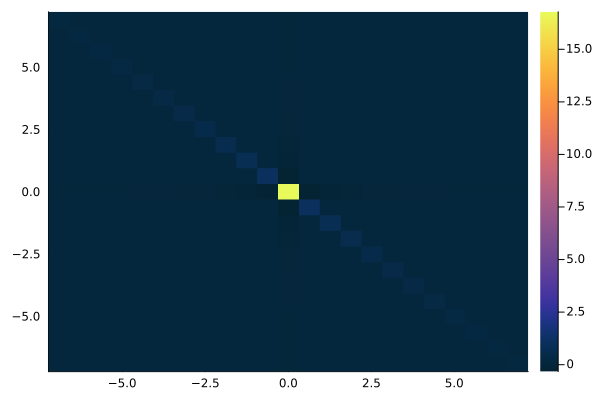

In [91]:
showMeThe(R4_omega)

In [92]:
A7 = c[1, 1]' * c[1, 1]
B7 = c[1, 1]' * c[1, 2]
C7 = c[1, 2]' * c[1, 1]

R7_tau = full_tau((A7,B7,C7), tautau, ham_eb, beta)

101×101 Matrix{Float64}:
 0.292711  2.23711e-17  4.50243e-17  6.16149e-17  …  2.3882e-16  2.70206e-16
 0.264083  0.227337     0.00142538   0.00213992      0.0274255   0.0367457
 0.243756  0.206106     0.181076     0.00213992      0.0469552   0.0626803
 0.228925  0.190861     0.164909     0.147511        0.0611964   0.081414
 0.21783   0.17961      0.153172     0.134889        0.0718202   0.0952558
 0.209339  0.171099     0.144415     0.125631     …  0.0799178   0.105707
 0.202708  0.164517     0.13772      0.118653        0.0862146   0.11376
 0.197431  0.159326     0.132493     0.113268        0.0912017   0.120084
 0.193164  0.15516      0.128335     0.109027        0.0952181   0.125137
 0.189663  0.151765     0.124971     0.105627        0.0985015   0.129238
 0.186753  0.14896      0.122211     0.102858     …  0.101222    0.132614
 0.184306  0.146614     0.119916     0.100572        0.103502    0.135427
 0.182228  0.144631     0.117988     0.0986615       0.105434    0.137798
 ⋮      

In [93]:
@time R7_omega = G_ABC_gl_transform_simplex(A7, B7, C7, H, beta, space, 11, 11)


558.061207 seconds (19.07 M allocations: 9.798 GiB, 0.24% gc time)


23×23 Matrix{ComplexF64}:
  -4.62656e-5-3.63235e-13im  …   -0.00140502-0.0509532im
  -5.40216e-5-0.000321498im     -0.000922872-0.0283461im
  -6.38002e-5-0.000753089im     -0.000693172-0.0179952im
  -7.62985e-5-0.00133787im      -0.000559932-0.0111381im
  -9.24879e-5-0.00213996im       -0.00047927-0.00612931im
 -0.000113709-0.00325791im   …     -0.000431-0.00196169im
 -0.000141755-0.00485016im      -0.000405753+0.00196169im
 -0.000178893-0.00718842im      -0.000398104+0.00612931im
 -0.000227779-0.0107811im       -0.000404226+0.0111381im
 -0.000291894-0.0166734im       -0.000421724+0.0179952im
 -0.000378027-0.0268351im    …  -0.000451753+0.0283461im
     0.137946-0.0509532im           0.137946+0.0509532im
 -0.000451753-0.0283461im       -0.000378027+0.0268351im
 -0.000421724-0.0179952im       -0.000291894+0.0166734im
 -0.000404226-0.0111381im       -0.000227779+0.0107811im
 -0.000398104-0.00612931im   …  -0.000178893+0.00718842im
 -0.000405753-0.00196169im      -0.000141755+0.00485016im

2.237891663713489


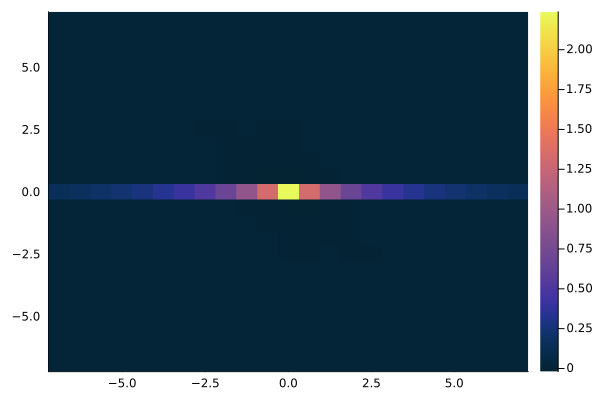

In [94]:
showMeThe(R7_omega)